## KMeans Clustering

Use the dataset in link:
https://www.kaggle.com/datasets/yasserh/customer-segmentation-dataset

1. Load the dataset -- 0.5 marks
2. Clean the dataset -- 0.5 marks
3. EDA -- 2 marks
4. Split the dataset  -- 0.5 marks
5. Encode and Standardization -- 0.5 marks
6. Select the correct number of ks  -- 2 marks
7. Modelling -- 2 marks
8. Result visualization -- 2 marks


In [1]:
import kagglehub

path = kagglehub.dataset_download("yasserh/customer-segmentation-dataset")

print("Path to dataset files:", path)

100%|██████████| 21.8M/21.8M [00:00<00:00, 32.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/yasserh/customer-segmentation-dataset/versions/1


In [3]:
!mv /root/.cache/kagglehub/datasets/yasserh/customer-segmentation-dataset/versions/1 .

In [6]:
!mv 1/* .

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [28]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [29]:
print("Missing values:\n", df.isnull().sum())

df.drop(columns=['CustomerID', 'InvoiceNo'], inplace=True)

df['Description'].fillna("No Description", inplace=True)

df.drop_duplicates(inplace=True)
print("Data shape after cleaning:", df.shape)

Missing values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


<ipython-input-29-a50b961cd0ef>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Description'].fillna("No Description", inplace=True)


Data shape after cleaning: (535885, 6)


In [30]:
df.columns

Index(['StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice',
       'Country'],
      dtype='object')

In [31]:
df.describe()

,Quantity,InvoiceDate,UnitPrice
count,535885.000000,535885,535885.000000
mean,9.646844,2011-07-04 10:53:40.231355648,4.631516
min,-80995.000000,2010-12-01 08:26:00,-11062.060000
25%,1.000000,2011-03-28 11:34:00,1.250000
50%,3.000000,2011-07-19 15:29:00,2.080000
75%,10.000000,2011-10-18 17:05:00,4.130000
max,80995.000000,2011-12-09 12:50:00,38970.000000
std,218.890996,NaN,97.301528


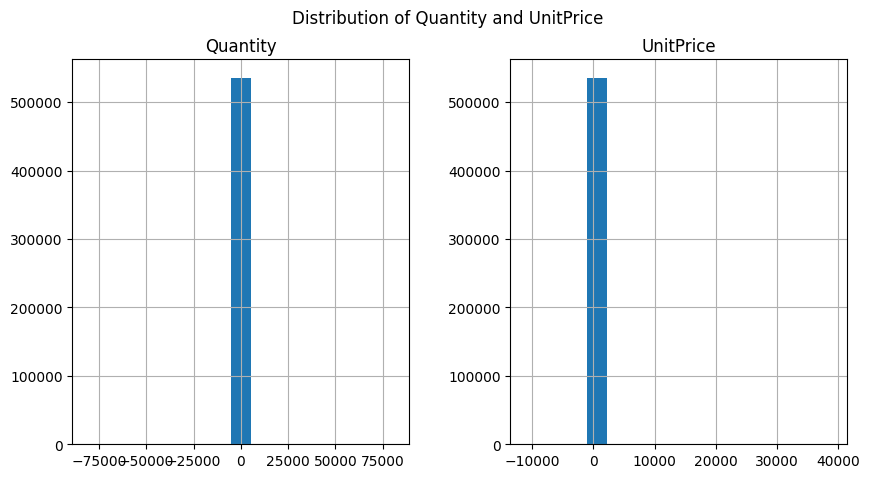

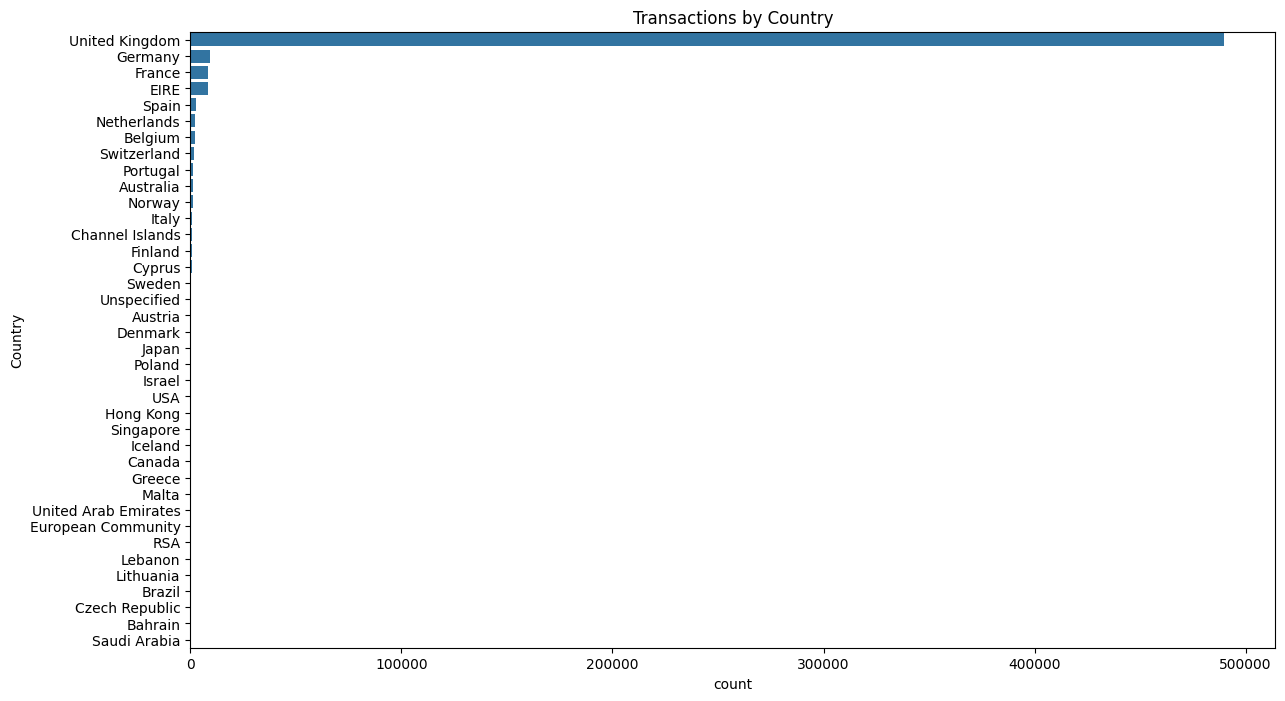

In [32]:
df[['Quantity', 'UnitPrice']].hist(bins=15, figsize=(10, 5))
plt.suptitle("Distribution of Quantity and UnitPrice")

plt.figure(figsize=(14, 8))
sns.countplot(y='Country', data=df, order=df['Country'].value_counts().index)
plt.title("Transactions by Country")
plt.show()

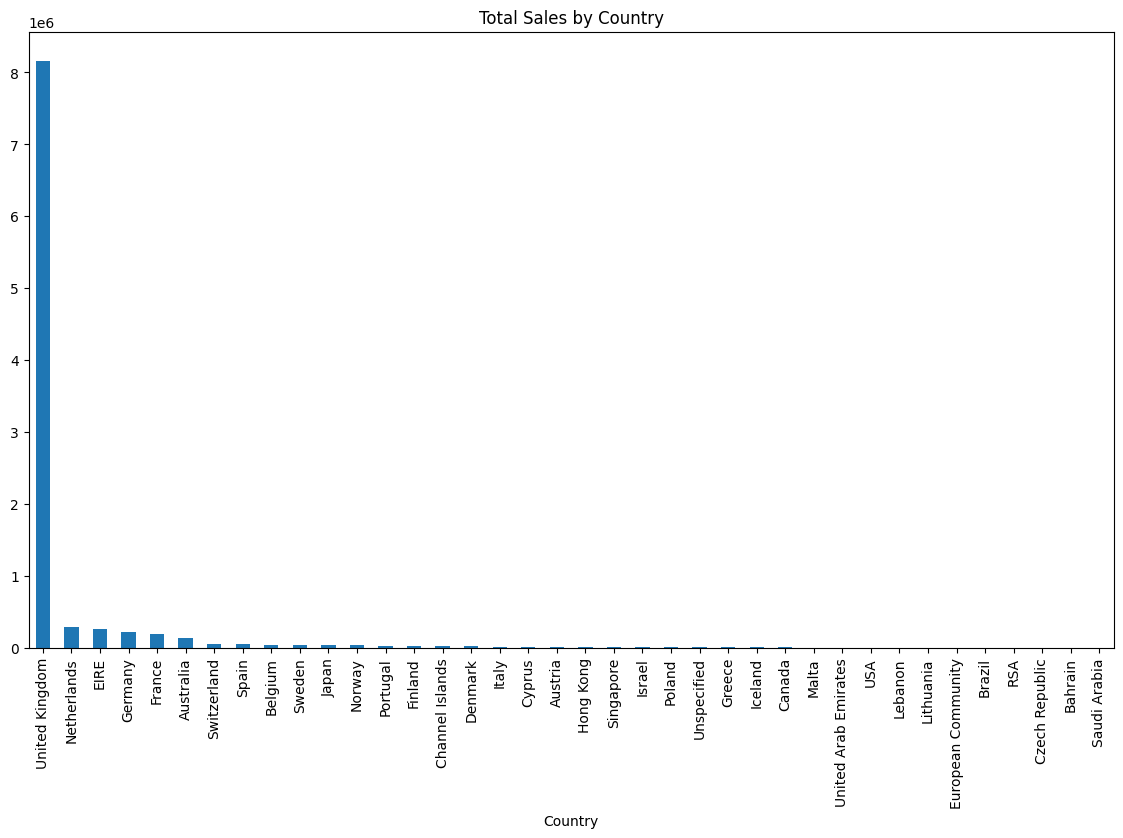

In [33]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
df['Hour'] = df['InvoiceDate'].dt.hour

country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
plt.figure(figsize=(14, 8))
country_sales.plot(kind='bar')
plt.title("Total Sales by Country")
plt.show()

In [36]:
X = df[['Quantity', 'UnitPrice', 'TotalPrice', 'Country']]

X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

In [40]:
numerical_features = ['Quantity', 'UnitPrice', 'TotalPrice']
categorical_features = ['Country']

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed.shape

(535885, 41)

In [48]:
from sklearn.cluster import MiniBatchKMeans

k_values = range(2, 6)

inertia = []
silhouette_scores = []

sample_size = int(0.1 * X_preprocessed.shape[0])
sampled_data = X_preprocessed[np.random.choice(X_preprocessed.shape[0], sample_size, replace=False)]

for k in k_values:
    print(f'k={k}')
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    kmeans.fit(sampled_data)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(sampled_data, kmeans.labels_))

k=2
k=3
k=4
k=5


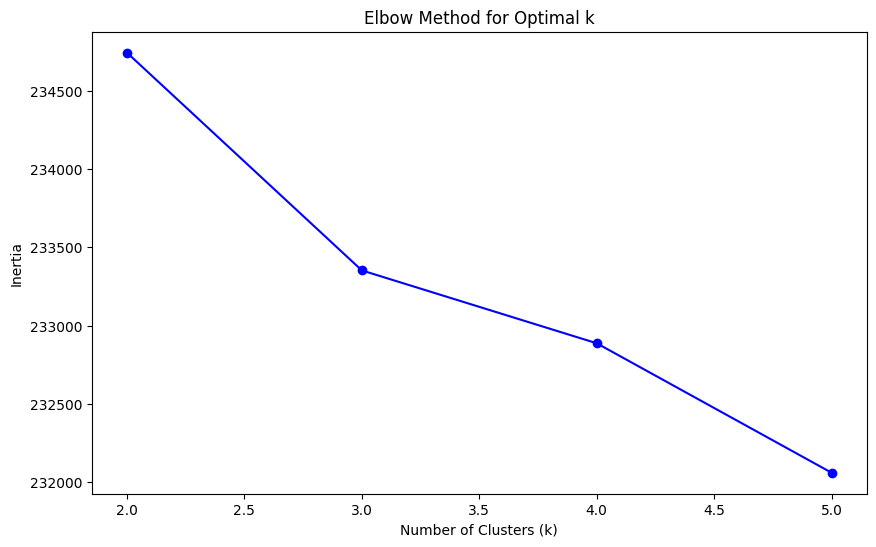

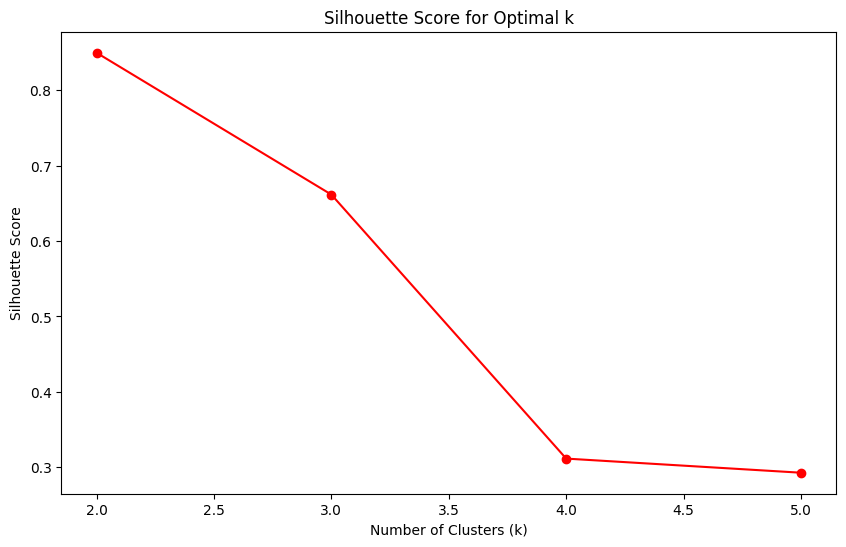

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Plot Silhouette Score
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal k')
plt.show()

In [43]:
optimal_k = 5
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_preprocessed)

# Add cluster labels to the original dataframe
df['Cluster'] = clusters

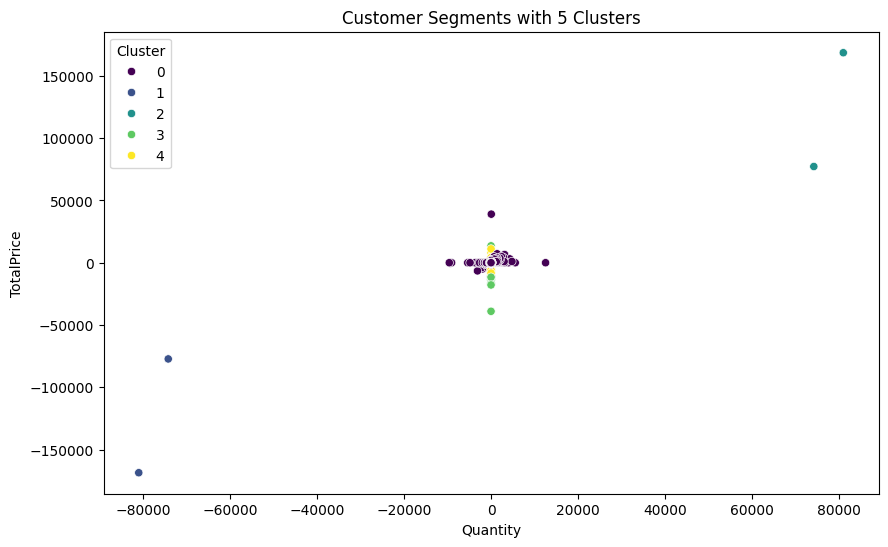

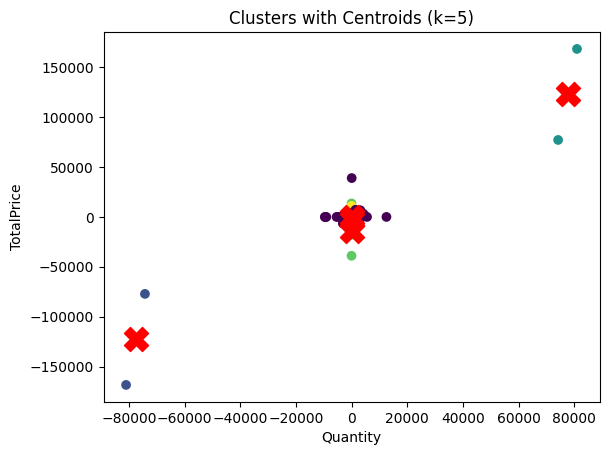

In [44]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Quantity'], y=df['TotalPrice'], hue=df['Cluster'], palette='viridis')
plt.title(f'Customer Segments with {optimal_k} Clusters')
plt.show()

# Centroid Visualization
centroids = kmeans.cluster_centers_
centroids_original_space = preprocessor.named_transformers_['num'].inverse_transform(centroids[:, :len(numerical_features)])

plt.scatter(df['Quantity'], df['TotalPrice'], c=clusters, cmap='viridis', marker='o')
plt.scatter(centroids_original_space[:, 0], centroids_original_space[:, 2], c='red', s=300, marker='X')  # Centroids
plt.xlabel('Quantity')
plt.ylabel('TotalPrice')
plt.title(f'Clusters with Centroids (k={optimal_k})')
plt.show()